# Stochastic Variational Inference for scalability with SVGP

One of the main criticisms of Gaussian processes is their scalability to large datasets. In this notebook, we illustrate how to use the state-of-the-art Stochastic Variational Gaussian Process (SVGP) (*Hensman, et. al. 2013*) to overcome this problem. 

In [1]:
%matplotlib inline
import itertools
import numpy as np
import numpy.random as rnd
import time
import gpflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from gpflow.ci_utils import ci_niter
plt.style.use('ggplot')

## Generating data
For this notebook example, we generate 10,000 noisy observations from a test function:
$$
f(x) = \sin(3\pi x) + 0.3\cos(9\pi x) + \frac{\sin(7 \pi x)}{2}
$$

In [2]:
def func(x):
    return np.sin(x * 3 * 3.14) + 0.3 * np.cos(x * 9 * 3.14) + 0.5 * np.sin(x * 7 * 3.14)

N = 10000  # Number of training observations

X = rnd.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rnd.randn(N, 1)  # Noisy Y values
data = (X, Y)

We plot the data along with the noiseless generating function:

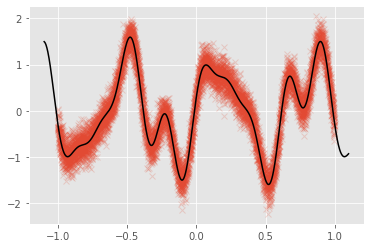

In [3]:
plt.plot(X, Y, 'x', alpha=0.2)
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
plt.plot(Xt, Yt, c='k');

## Building the model
The main idea behind SVGP is to approximate the true GP posterior with a GP conditioned on a small set of "inducing" values. This smaller set can be thought of as summarizing the larger dataset. For this example, we will select a set of 50 inducing locations that are initialized from the training dataset:

In [4]:
M = 50  # Number of inducing locations

kernel = gpflow.kernels.SquaredExponential()
Z = X[:M, :].copy()  # Initialize inducing locations to the first M inputs in the dataset

m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=N)

## Likelihood computation: batch vs. minibatch
First we showcase the model's performance using the whole dataset to compute the ELBO.

In [5]:
log_likelihood = tf.function(autograph=False)(m.log_likelihood)

In [6]:
%%timeit
log_likelihood(data)

8.63 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can speed up this calculation by using minibatches of the data. For this example, we use minibatches of size 100.

In [7]:
minibatch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)) \
    .repeat() \
    .shuffle(N)

train_it = iter(train_dataset.batch(minibatch_size))

ground_truth = m.log_likelihood(data).numpy()

In [8]:
%%timeit
log_likelihood(next(train_it))

1.09 ms ± 73.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [9]:
evals = [log_likelihood(minibatch).numpy()
         for minibatch in itertools.islice(train_it, 100)]

Discrepancy between ground truth and minibatch estimate: -31.95501790219714


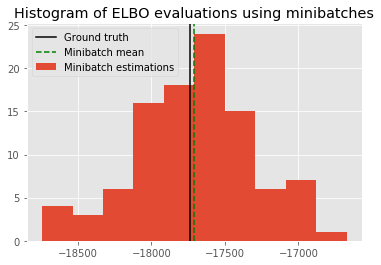

In [10]:
plt.hist(evals, label='Minibatch estimations')
plt.axvline(ground_truth, c='k', label='Ground truth')
plt.axvline(np.mean(evals), c='g', ls='--', label='Minibatch mean')
plt.legend()
plt.title('Histogram of ELBO evaluations using minibatches')
print("Discrepancy between ground truth and minibatch estimate:",
      ground_truth - np.mean(evals))

### Minibatches speed up computation
The reason for using minibatches is that it decreases the time needed to make an optimization step, because estimating the objective is computationally cheaper with fewer data points. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [11]:
# Evaluate objective for different minibatch sizes
minibatch_proportions = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in minibatch_proportions:
    batchsize = int(N * mbp)
    train_it = iter(train_dataset.batch(batchsize))
    start_time = time.time()
    objs.append([log_likelihood(minibatch)
                 for minibatch in itertools.islice(train_it, 20)])
    times.append(time.time() - start_time)

Text(0, 0.5, 'ELBO estimates')

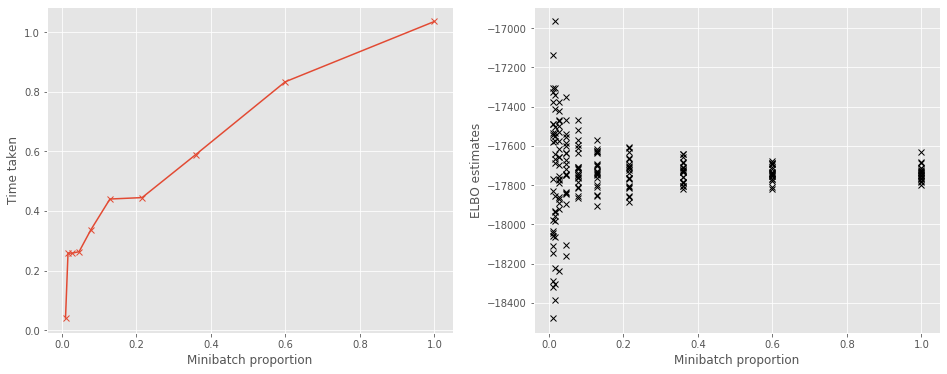

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(minibatch_proportions, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(minibatch_proportions, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")

### Running stochastic optimization

First we create a utility function that plots the model's predictions:

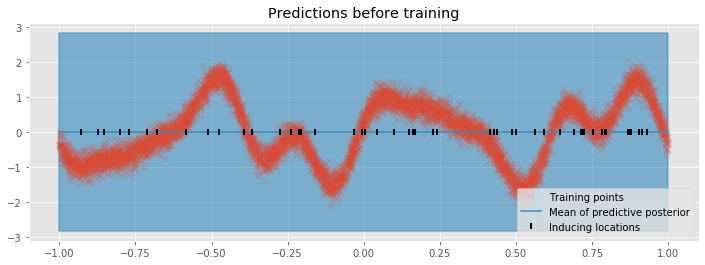

In [13]:
def plot(title=''):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    pX = np.linspace(-1, 1, 100)[:, None]  # Test locations
    pY, pYv = m.predict_y(pX)  # Predict Y values at test locations
    plt.plot(X, Y, 'x', label='Training points', alpha=0.2)
    line, = plt.plot(pX, pY, lw=1.5, label='Mean of predictive posterior')
    col = line.get_color()
    plt.fill_between(pX[:, 0], (pY-2*pYv**0.5)[:, 0], (pY+2*pYv**0.5)[:, 0], 
                     color=col, alpha=0.6, lw=1.5)
    Z = m.inducing_variable.Z.numpy()
    plt.plot(Z, np.zeros_like(Z), 'k|', mew=2, label='Inducing locations')
    plt.legend(loc='lower right')

plot(title="Predictions before training")

Now we can train our model. For optimizing the ELBO, we use the Adam Optimizer *(Kingma and Ba 2015)* which is designed for stochastic objective functions. We create a `run_adam` utility function  to perform the optimization.

In [14]:
minibatch_size = 100

# We turn off training for inducing point locations
gpflow.utilities.set_trainable(m.inducing_variable, False)

@tf.function(autograph=False)
def optimization_step(optimizer, model: gpflow.models.SVGP, batch):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = - model.elbo(batch)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer
    
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_it = iter(train_dataset.batch(minibatch_size))
    adam = tf.optimizers.Adam()
    for step in range(iterations):
        elbo = - optimization_step(adam, model, next(train_it))
        if step % 10 == 0:
            logf.append(elbo.numpy())
    return logf

Now we run the optimization loop for 10,000 iterations.

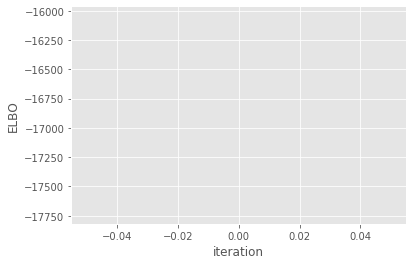

In [15]:
maxiter = ci_niter(20000)

logf = run_adam(m, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');

Finally, we plot the model's predictions.

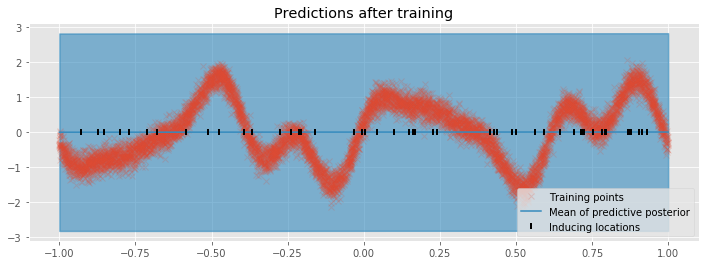

In [16]:
plot("Predictions after training")

## Further reading

Several notebooks expand on this one:

- [Advanced Sparse GP regression](../advanced/advanced_many_points.ipynb), which goes into deeper detail on sparse Gaussian process methods.
- [Optimization](../advanced/optimisation.ipynb) discussing optimizing GP models.
- [Natural gradients](../advanced/natural_gradients.ipynb) for optimizing SVGP models efficiently.

## References:
Hensman, James, Nicolo Fusi, and Neil D. Lawrence. "Gaussian processes for big data." Uncertainty in Artificial Intelligence (2013).

Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).